(100,)


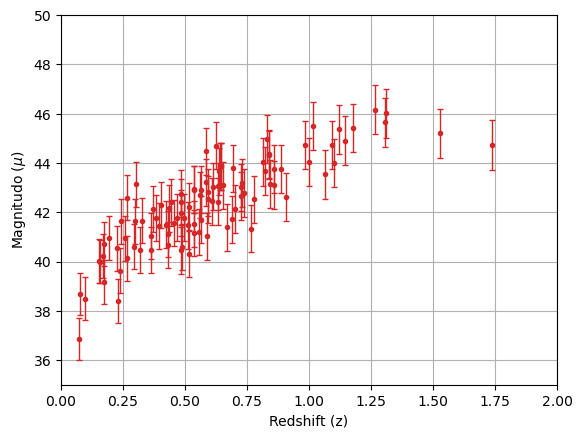

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) # YOU CANNOT CHANGE THIS

print(np.shape(z_sample))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.', lw=1, capsize = 2, label='data', color='tab:red' )
plt.xlabel("Redshift (z)")
plt.ylabel(rf"Magnitudo $(\mu)$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.grid()

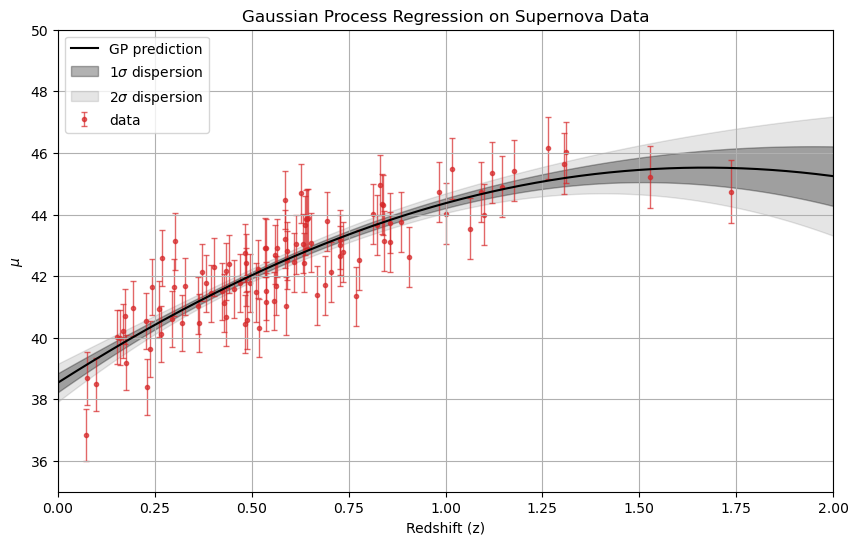

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf_kernel =  ConstantKernel(1.0, (1e-3, 1e3))*RBF(length_scale=10, length_scale_bounds=(1e-2, 1e2))  # RBF kernel with a length scale of 0.1
# The length_scale_bounds parameter allows the optimizer to adjust the length scale during fitting
gp = GaussianProcessRegressor(kernel=rbf_kernel, alpha = dmu**2, n_restarts_optimizer=10)  #I've added 10 optimization iterations
gp.fit(z_sample.reshape(-1,1), mu_sample)
z_fit = np.linspace(0, 2, 1000)
mu_pred, dmu_pred = gp.predict(z_fit.reshape(-1,1), return_std=True)

fig2,ax2= plt.subplots(figsize=(10,6))
ax2.plot(z_fit, mu_pred, label='GP prediction', color = 'black', zorder=5)
ax2.fill_between(z_fit, mu_pred-dmu_pred, mu_pred+dmu_pred, alpha=0.3, label=rf'1$\sigma$ dispersion', color = 'black', zorder=1)
ax2.fill_between(z_fit, mu_pred-2*dmu_pred, mu_pred+2*dmu_pred, alpha=0.1, label=rf'2$\sigma$ dispersion', color = 'black', zorder=1)
ax2.errorbar(z_sample, mu_sample, dmu, fmt='.', lw=1, capsize = 2, label='data', color = 'tab:red', alpha=0.7, zorder=1)
ax2.set_title("Gaussian Process Regression on Supernova Data")
ax2.grid()
ax2.set_xlabel("Redshift (z)")
ax2.set_ylabel(rf"$\mu$")
ax2.set_xlim(0,2)
ax2.set_ylim(35,50)
ax2.legend()


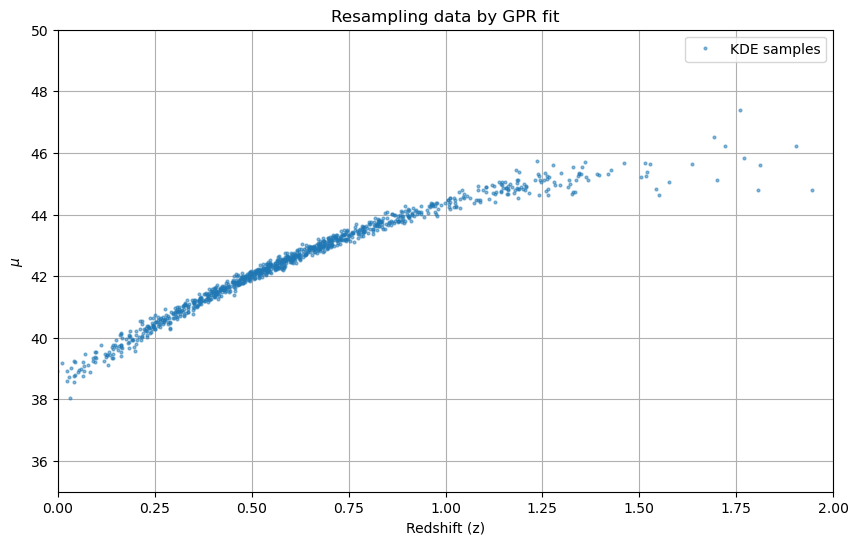

In [4]:
from sklearn.neighbors import KernelDensity

fig3, ax3 = plt.subplots(figsize=(10,6))
kde = KernelDensity(kernel='gaussian', bandwidth=0.1)
kde.fit(z_sample.reshape(-1, 1))
z_copy = kde.sample(1000, random_state=42)
mu_gp, dmu_gp = gp.predict(z_copy.reshape(-1, 1), return_std=True) 
mu_copy = mu_gp + np.random.normal(0, dmu_gp)  # Adding noise to the GP prediction
ax3.plot(z_copy, mu_copy, 'o', markersize=2, label='KDE samples', color='tab:blue', alpha=0.5)
ax3.set_title("Resampling data by GPR fit")
ax3.set_xlabel("Redshift (z)")
ax3.set_ylabel(rf"$\mu$")
ax3.set_xlim(0,2)
ax3.set_ylim(35,50)
ax3.grid()
ax3.legend()



In [5]:
import emcee
from astropy.cosmology import LambdaCDM
import corner

def model(z, params):
    H0, Om = params
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value

def LogLikelihood(params, z, mu, dmu):
    H0, Om = params
    mu_model = model(z,params)
    return -0.5*(len(z)*np.log(2*np.pi) + np.sum(2*np.log(dmu) + ((mu - mu_model)/dmu)**2)) #writing it already normalized to use it also for dynesty

def LogPrior(params):
    H0, Om = params
    if 50 < H0 < 100 and 0 < Om < 1:
        return 1.   #Uniform prior for H0 in [50,100] and Om in [0,1]
    return -np.inf  # Outside the prior range

def LogPosterior(params, z, mu, dmu):
    H0, Om = params
    lp = LogPrior(params)
    if np.isfinite(lp):
        return lp + LogLikelihood(params, z, mu, dmu)
    return -np.inf  # If prior is not finite, return -inf


In [22]:
ndim = 2 
nwalkers = 10 
nsteps = 10000
np.random.seed(42)


starting_guesses = np.array([70, 0.3]) + 1e-1*np.random.randn(nwalkers, ndim) 
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=(z_sample, mu_sample, dmu))
sampler.run_mcmc(starting_guesses, nsteps, progress=True)
acceptance_rates = sampler.acceptance_fraction
print("Acceptance rates:", acceptance_rates)
emcee_trace  = sampler.get_chain()


100%|██████████| 10000/10000 [05:26<00:00, 30.61it/s]

Acceptance rates: [0.6841 0.6885 0.6859 0.6981 0.6867 0.6871 0.6836 0.6808 0.6888 0.6886]


Text(0.5, 0.98, 'MCMC Trace for Cosmological Parameters')

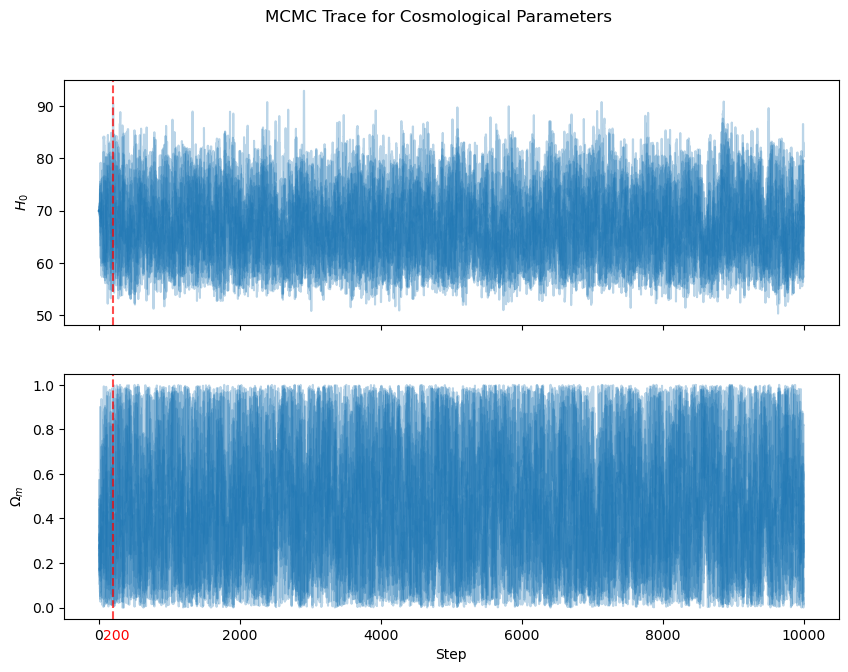

In [20]:
burn = 200
fig1, ax1 = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = [r"$H_0$", r"$\Omega_m$"]
steps = np.arange(nsteps)
for i in range(ndim):
    ax1[i].plot(steps, emcee_trace[:,:, i], alpha=0.3, color ='#1f77b4')
    ax1[i].axvline(x=burn, color='red', linestyle='--', alpha=0.7)
    if i == ndim - 1:
        ax1[i].annotate(f'{burn}', 
                         xy=(burn, ax1[i].get_ylim()[0]),     # x pos, bottom of y-axis
                         xytext=(-7,-7), 
                         textcoords='offset points',
                         ha='left', va='top',
                         fontsize=10, color='red',
        )
    ax1[i].set_ylabel(labels[i])
ax1[-1].set_xlabel("Step")
fig1.suptitle("MCMC Trace for Cosmological Parameters")

Autocorrelation times for the 4 parameters: [37.58395588 39.77349738]
Traces after burn-in and thinning
Estimated values of parameters with 5th and 95th percentiles


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0.5, 0.98, 'MCMC Trace for Cosmological Parameters after Burn-in and Thinning')

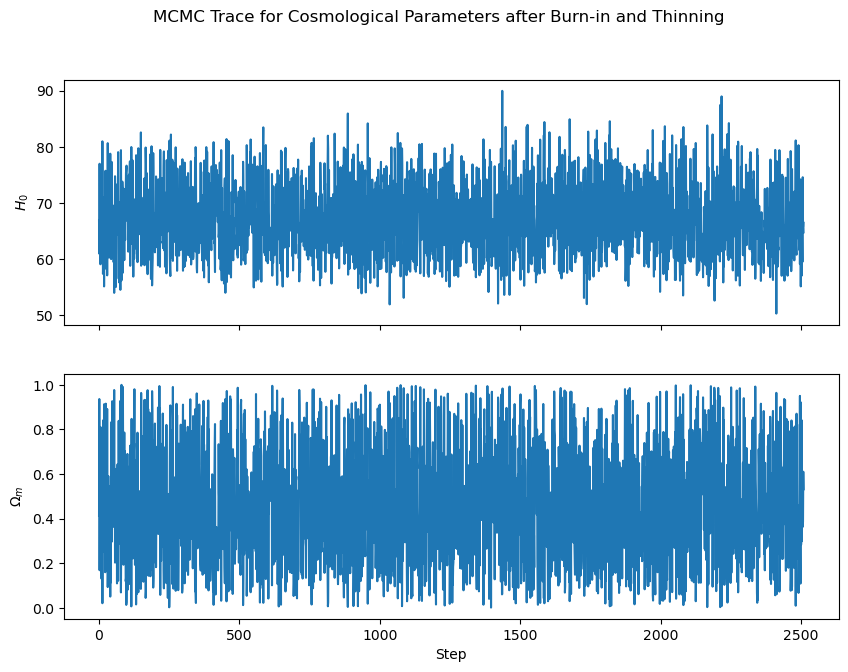

In [21]:
#autocorrelation time
tau = sampler.get_autocorr_time(tol = 0)
print("Autocorrelation times for the 4 parameters:", tau)
thin = int(np.max(tau))
emcee_trace = sampler.get_chain(discard=burn, thin=thin, flat=True).reshape(-1, ndim)

print("Traces after burn-in and thinning")
fig2, ax2 = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax2[i].plot(emcee_trace[:, i])
    ax2[i].set_ylabel(labels[i])
ax2[-1].set_xlabel("Step")

from IPython.display import display, Math
H0_median = np.median(emcee_trace[:, 0])    
Om_median = np.median(emcee_trace[:, 1])
H_lowedge =  H0_median - np.percentile(emcee_trace[:,0], 5)
Om_lowedge =  Om_median - np.percentile(emcee_trace[:,1], 5)
H_upedge = np.percentile(emcee_trace[:,0], 95) - H0_median
Om_upedge =  np.percentile(emcee_trace[:,1], 95) - Om_median
print("Estimated values of parameters with 5th and 95th percentiles")
display(Math (rf"\text{{H}}_0: {H0_median:.2f}^{{+{H_upedge:.2f}}}_{{{-H_lowedge:.2f}}}~\frac{{\mathrm{{GeV}}}}{{\mathrm{{cm}}^2\,\mathrm{{s}}}}"))
display(Math (rf"\Omega_m: {Om_median:.2f}^{{+{Om_upedge:.2f}}}_{{{-Om_lowedge:.2f}}}~\frac{{\mathrm{{GeV}}}}{{\mathrm{{cm}}^2\,\mathrm{{s}}}}"))
fig2.suptitle("MCMC Trace for Cosmological Parameters after Burn-in and Thinning")

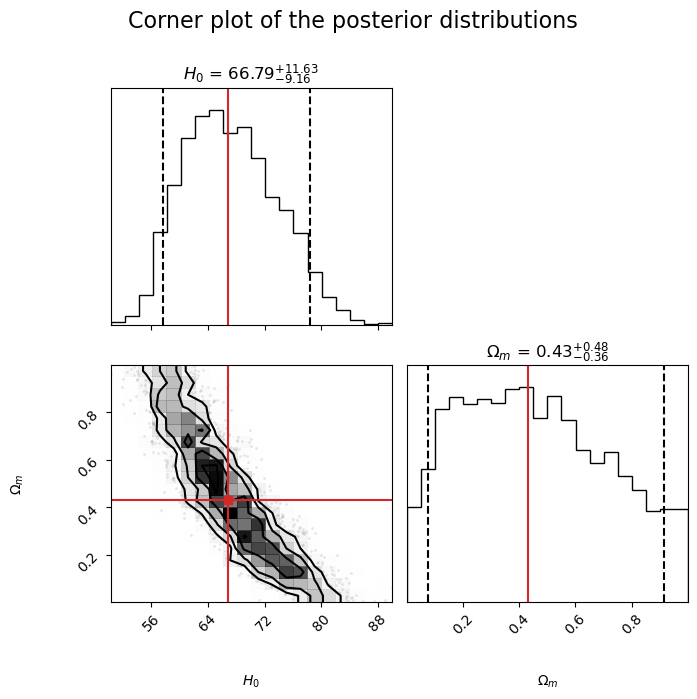

In [9]:
fig3 = plt.figure(figsize=(7, 7))
corner.corner(emcee_trace, labels=labels, quantiles=(0.05, 0.95), 
              show_titles=True, title_quantiles=(0.05, 0.5, 0.95), 
              title_kwargs={"fontsize": 12}, fig = fig3, 
              truths=[H0_median, Om_median], truth_color='tab:red')
fig3.suptitle("Corner plot of the posterior distributions", fontsize=16, y=1)
#plt.subplots_adjust(left = 0.001, right = 0.999)
plt.tight_layout()

In [10]:
import dynesty
import scipy.stats

def Prior(u):
    x = np.array(u) 
    x[0] = scipy.stats.uniform(loc=50,scale=40).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=0, scale=1).ppf(u[1])
    return x

sampler = dynesty.NestedSampler(LogLikelihood, Prior, 
                                      ndim, logl_args=[z_sample, mu_sample, dmu], nlive=1000)
sampler.run_nested(dlogz = 0.1, maxiter=10000)
results = sampler.results


4359it [04:21, 16.70it/s, +1000 | bound: 2 | nc: 1 | ncall: 38864 | eff(%): 14.153 | loglstar:   -inf < -132.813 <    inf | logz: -134.822 +/-  0.033 | dlogz:  0.000 >  0.100]


Estimated values of parameters with 5th and 95th percentiles


<IPython.core.display.Math object>

<IPython.core.display.Math object>

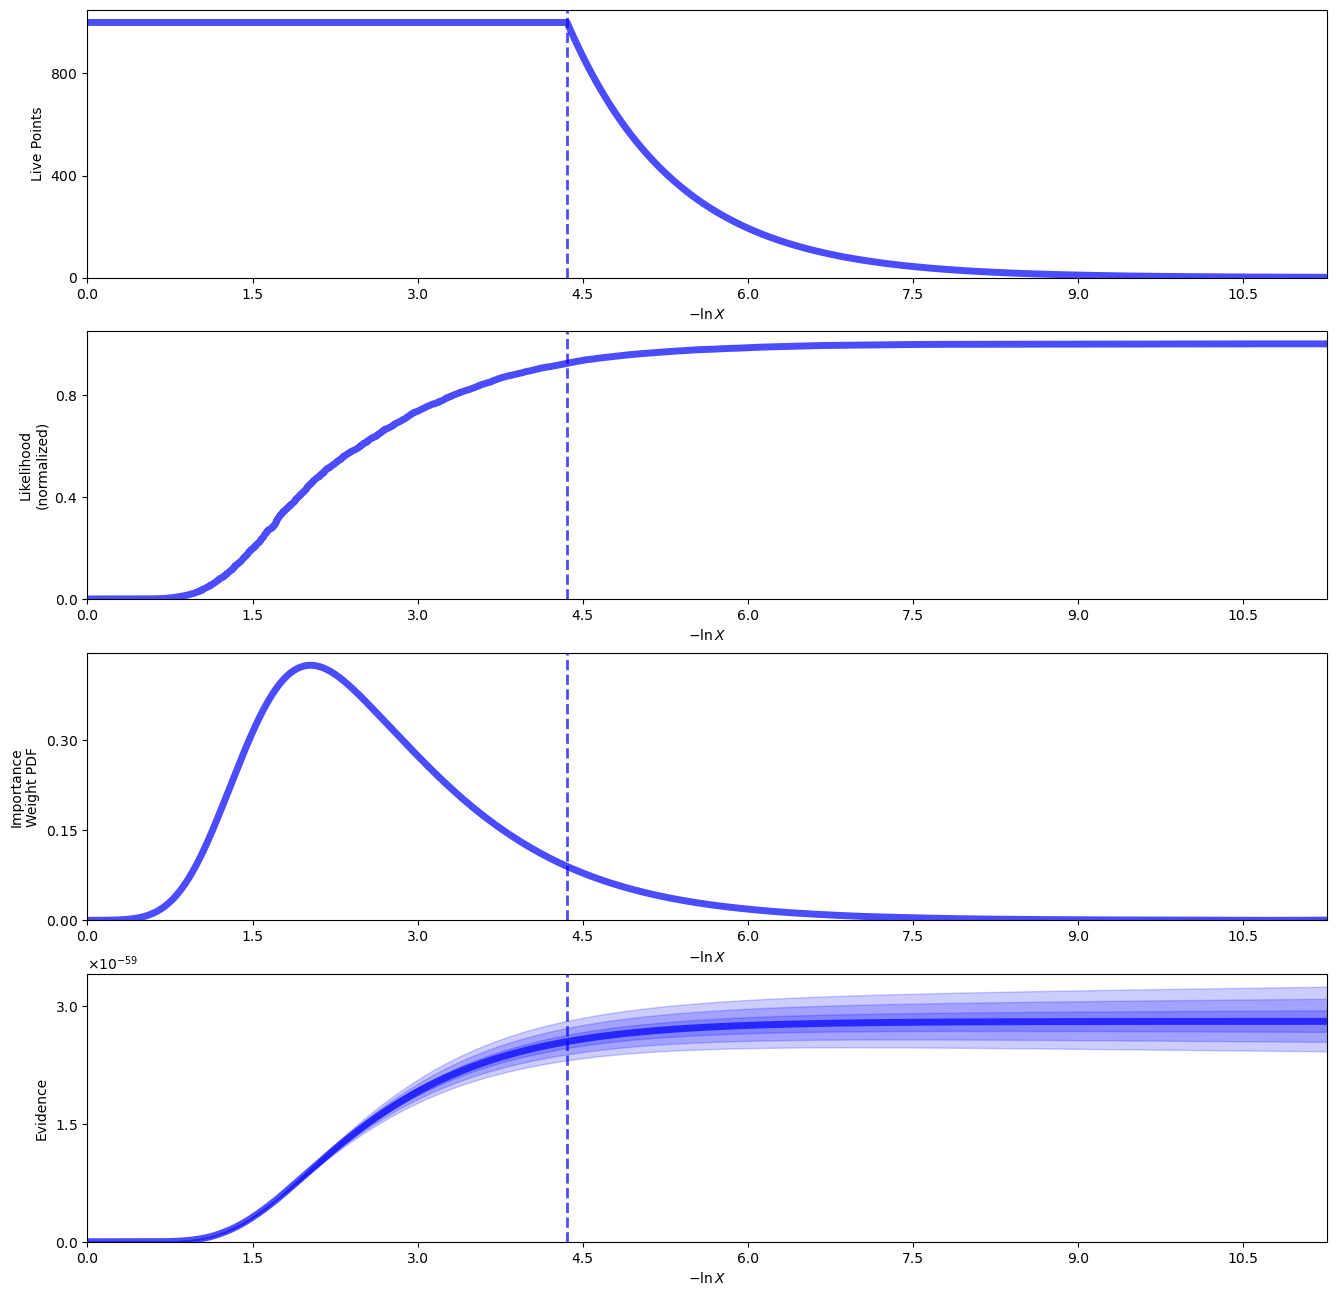

In [11]:
# Extract sampling results.
samples= results.samples  # samples
weights = np.exp(results.logwt - results.logz[-1])  # normalized weights

#Reconstructing posterior distributions with weighted samples
from dynesty import utils as dyfunc

d_medians = np.array([dyfunc.quantile(x, [0.5], weights=weights) for x in samples.T])
H0_d_median = float(d_medians[0].item())
Om_d_median = float(d_medians[1].item())
low_edges = np.array([dyfunc.quantile(x, [0.05], weights=weights) for x in samples.T])
up_edges = np.array([dyfunc.quantile(x, [0.95], weights=weights) for x in samples.T])
H_d_lowedge = H0_d_median - float(low_edges[0].item())
Om_d_lowedge =  Om_d_median - float(low_edges[1].item())
H_d_upedge = float(up_edges[0].item()) - H0_d_median
Om_d_upedge = float(up_edges[1].item()) - Om_d_median

print("Estimated values of parameters with 5th and 95th percentiles")
display(Math (rf"\text{{H}}_0: {H0_d_median:.2f}^{{+{H_d_upedge:.2f}}}_{{{-H_d_lowedge:.2f}}}~\frac{{\mathrm{{GeV}}}}{{\mathrm{{cm}}^2\,\mathrm{{s}}}}"))
display(Math (rf"\Omega_m: {Om_d_median:.2f}^{{+{Om_d_upedge:.2f}}}_{{{-Om_d_lowedge:.2f}}}~\frac{{\mathrm{{GeV}}}}{{\mathrm{{cm}}^2\,\mathrm{{s}}}}"))


from dynesty import plotting as dyplot
fig4, ax4 = dyplot.runplot(results)

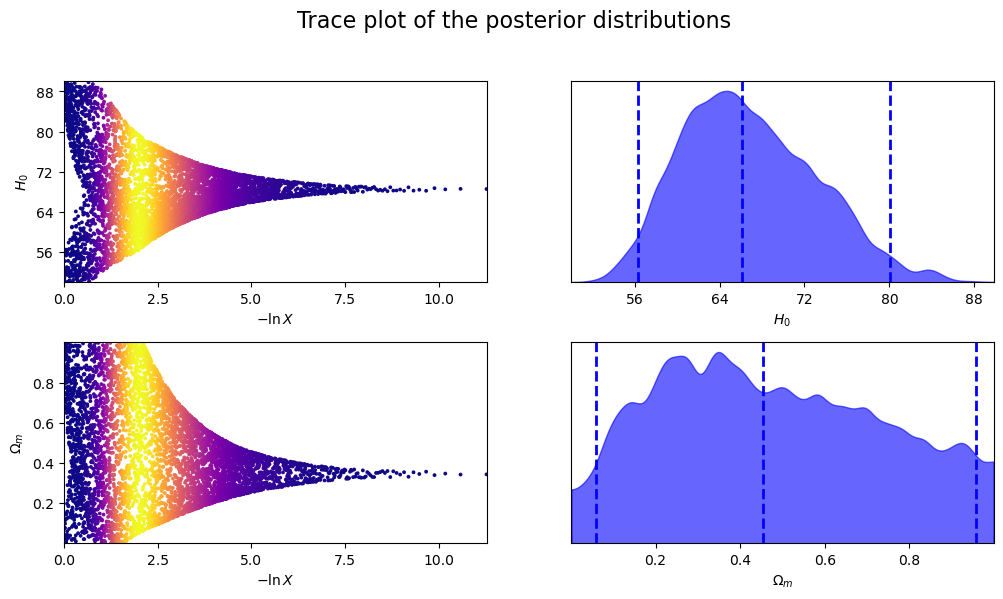

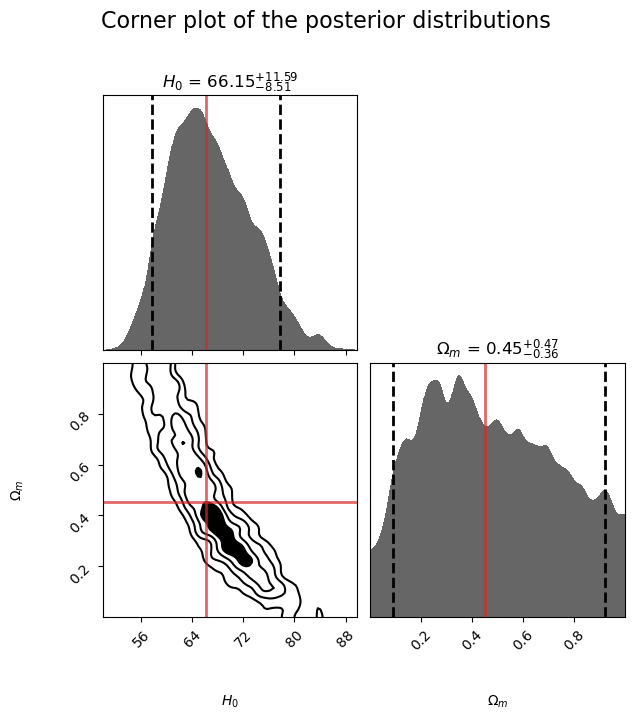

In [12]:
fig5, ax5 = dyplot.traceplot(results, labels=labels)
fig5.suptitle("Trace plot of the posterior distributions", fontsize=16, y=1)
fig5.subplots_adjust(hspace=0.3)


fig6, ax6 = dyplot.cornerplot(results, labels=labels, quantiles=(0.05, 0.95), 
                              show_titles=True, title_quantiles=(0.05, 0.5, 0.95), 
                              title_kwargs={"fontsize": 12}, 
                              truths=[H0_d_median, Om_d_median], truth_color='tab:red')

fig6.suptitle("Corner plot of the posterior distributions", fontsize=16, y=1.05)
fig6.set_size_inches(7,7)

In [13]:
evidence = results.logz[-1] #evidence for burst model
display(Math(rf"\text{{Bayesian evidence for model with }} \Omega_m \text{{ not fixed:}}\quad {np.exp(evidence):.2e}"))


<IPython.core.display.Math object>

In [14]:
#REPEATING DYNESTY BY FIXING OMEGA_m = 1
#finding by the ratio of bayesian evidences if data shows no evidence for dark energy
def Prior_fixed_om(u): 
    x = scipy.stats.uniform(loc=50,scale=40).ppf(u[0])
    return np.array([x])

def LogLikelihood_fixed_om(params, z, mu, dmu):
    H0 = float(params.item())
    Om = 1.0  # Fixing Omega_m to 1
    mu_model = model(z, [H0, Om])
    return -0.5*(len(z)*np.log(2*np.pi) + np.sum(2*np.log(dmu) + ((mu - mu_model)/dmu)**2))

sampler_fixed_om = dynesty.NestedSampler(LogLikelihood_fixed_om, Prior_fixed_om,
                                      1, logl_args=[z_sample, mu_sample, dmu], nlive=1000)
sampler_fixed_om.run_nested(dlogz = 0.1, maxiter=10000)
results_fixed_om = sampler_fixed_om.results

4254it [02:29, 28.52it/s, +1000 | bound: 1 | nc: 1 | ncall: 38647 | eff(%): 13.956 | loglstar:   -inf < -133.530 <    inf | logz: -135.430 +/-  0.033 | dlogz:  0.000 >  0.100]


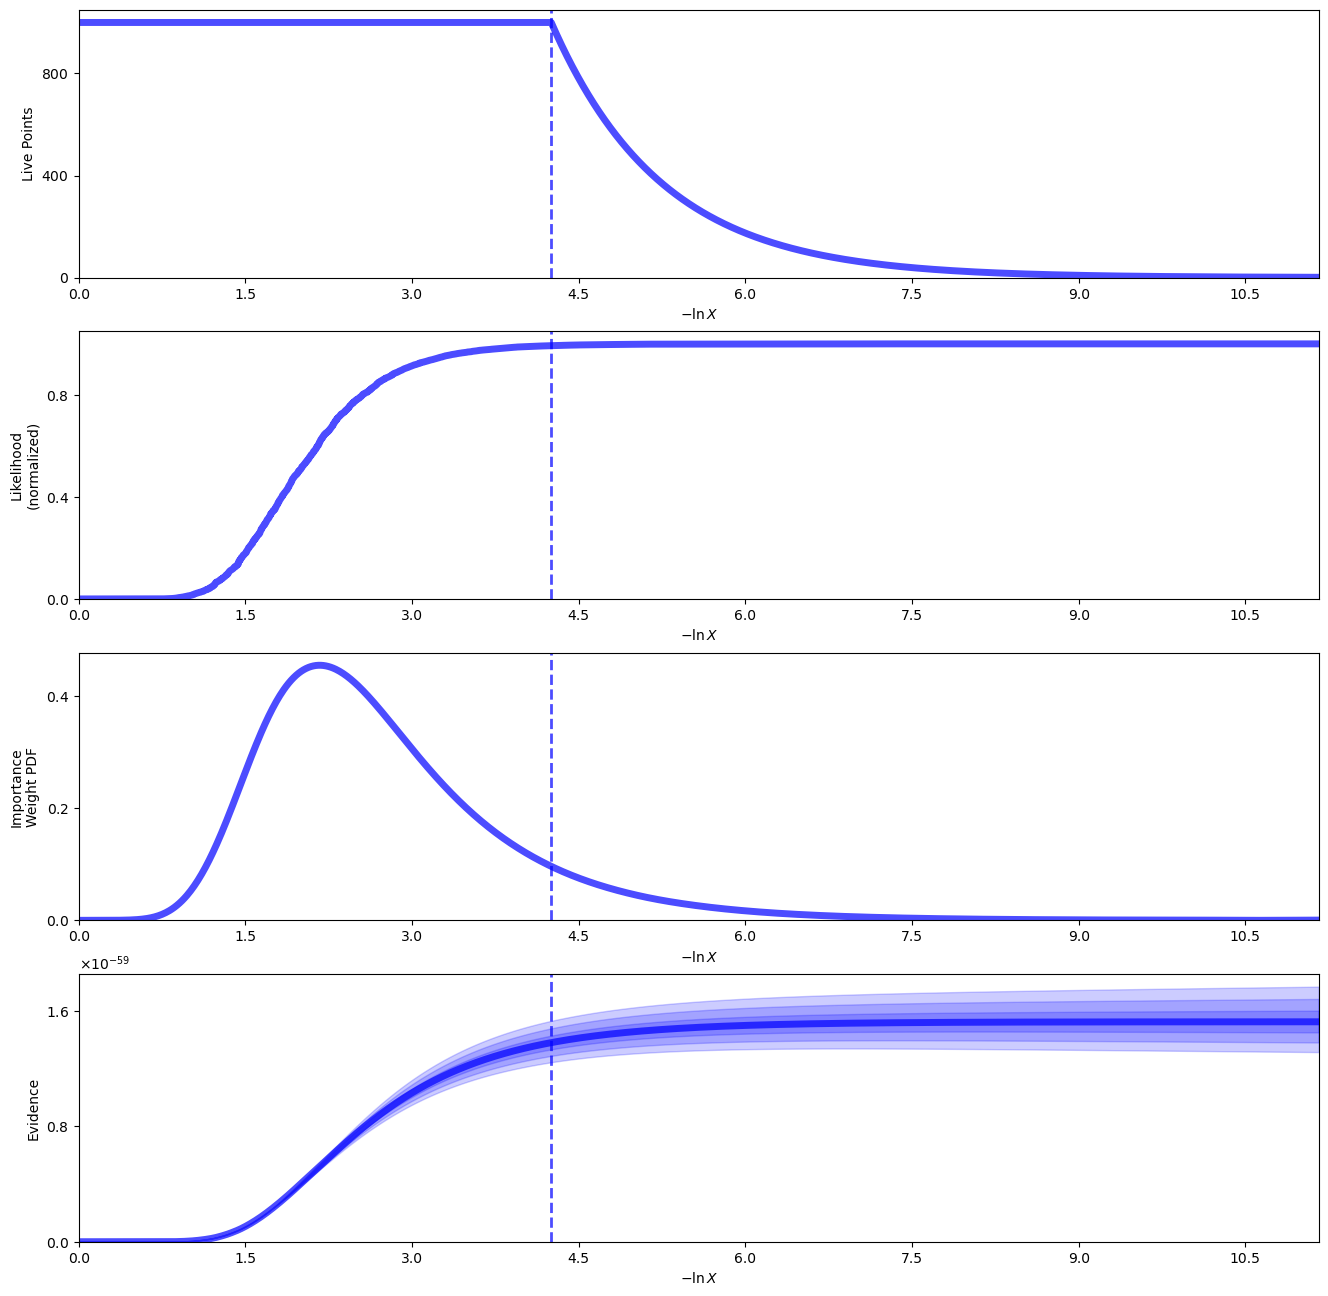

In [15]:
fig7, ax7 = dyplot.runplot(results_fixed_om)

(1, 1)
Estimated values of parameters with 5th and 95th percentiles


<IPython.core.display.Math object>

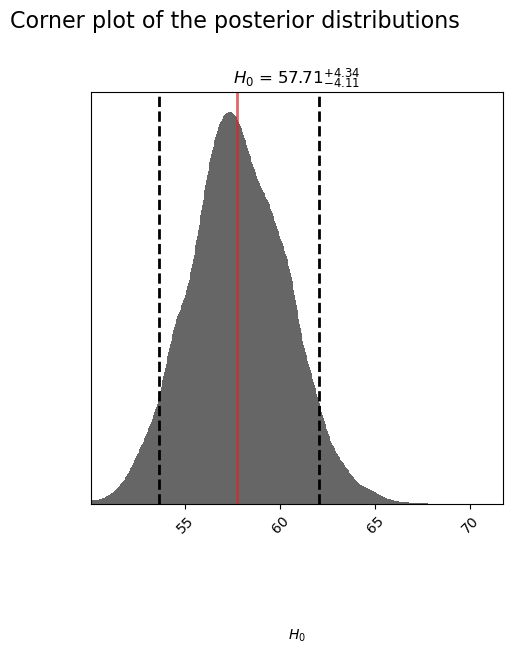

In [16]:
samples_fixed_om = results_fixed_om.samples  # samples
weights_fixed_om = np.exp(results_fixed_om.logwt - results_fixed_om.logz[-1])  # normalized weights

d_medians = np.array([dyfunc.quantile(x, [0.5], weights=weights_fixed_om) for x in samples_fixed_om.T])
H0_b = float(d_medians[0].item())
print(d_medians.shape)
low_edges_b = np.array([dyfunc.quantile(x, [0.05], weights=weights_fixed_om) for x in samples_fixed_om.T])
up_edges_b = np.array([dyfunc.quantile(x, [0.95], weights=weights_fixed_om) for x in samples_fixed_om.T])
H_b_lowedge = H0_b - float(low_edges_b[0].item())
H_b_upedge = float(up_edges_b[0].item()) - H0_b


print("Estimated values of parameters with 5th and 95th percentiles")
display(Math (rf"\text{{H}}_0: {H0_b:.2f}^{{+{H_b_upedge:.2f}}}_{{{-H_b_lowedge:.2f}}}~\frac{{\mathrm{{GeV}}}}{{\mathrm{{cm}}^2\,\mathrm{{s}}}}"))

labelH = [r"$H_0$"]  # Label for the corner plot
fig8, ax8 = dyplot.cornerplot(results_fixed_om, labels=labelH, quantiles=(0.05, 0.95), 
                              show_titles=True, title_quantiles=(0.05, 0.5, 0.95), 
                              title_kwargs={"fontsize": 12}, 
                              truths=[H0_b], truth_color='tab:red')

fig8.suptitle("Corner plot of the posterior distributions", fontsize=16, y=1.0)
fig8.set_size_inches(7,7)

In [17]:
evidence_fixed_om = results_fixed_om.logz[-1] 
display(Math(rf"\text{{Bayesian evidence for model with }} \Omega_m=1\text{{:}}\quad{np.exp(evidence_fixed_om):.2e}"))
# Ratio of evidences
ratio = np.exp(evidence-evidence_fixed_om)
display(Math(rf"\text{{Ratio of evidences:}}\quad\frac{{\mathrm{{\text{{BE}}\,(\forall\,\Omega_m)}}}}{{\mathrm{{\text{{BE}}\,(\Omega_m = 1)}}}}= {ratio:.2f}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>